In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [5]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
df_1 = df_1[ df_1['timed_fix'] > df_1['intended_fix'] ]

In [6]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [7]:
vp_sample = vp.sample(int(1e6))[0]

In [8]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
# t_A_aff = np.mean(vp_sample[:,2]) - t_motor
t_A_aff = 0.05 # NOTE: TEMP, to test if negative afferent delay is causing VBMC to not converge

In [9]:
t_A_aff

0.05

# VBMC

## loglike fn

In [10]:
def compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']

    rt = timed_fix
    t_stim = intended_fix
    
    K_max = 10

    if choice == 3:
        likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, \
                                    theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]
    elif choice == 2:
        likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,\
                                        theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params


    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L)\
                                       for _, row in df_1.iterrows() if (row['timed_fix'] > row['intended_fix']) \
                                        and (row['response_poke'] in [2,3]))

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [16]:
rate_lambda_bounds = [0.01, 0.3]
theta_E_bounds = [10, 90]
T_0_bounds = [0.1*(1e-3), 2*(1e-3)]


t_E_aff_bounds = [0.001, 0.1]
Z_E_bounds = [-10, 10]
L_bounds = [0.1, 1.99]

# ---
rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_E_aff_plausible_bounds = [0.01, 0.05]
Z_E_plausible_bounds = [-5, 5]
L_plausible_bounds = [0.5, 1.5]

## prior

In [17]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + L_logpdf


## prior + loglike

In [18]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [19]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_E_aff_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                t_E_aff_bounds[1], Z_E_bounds[1], L_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                t_E_aff_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                t_E_aff_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        5268.53      5386.85          inf        2        inf     start warm-up
     1         15       14293.43      7804.80      4275.10        2        inf     
     2         20       12717.07      5615.41      4144.42        2   8.04e+04     
     3         25       13113.43      4257.67     97900.65        2   1.35e+06     
     4         30       16181.70      2695.40     24559.77        2   3.53e+05     
     5         35       15763.28      1304.06      2116.81        2   3.45e+04     
     6         40       14118.93      1552.07     97782.91        2   1.34e+06     
     7         45       19768.08      5123.8

## corner plots

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


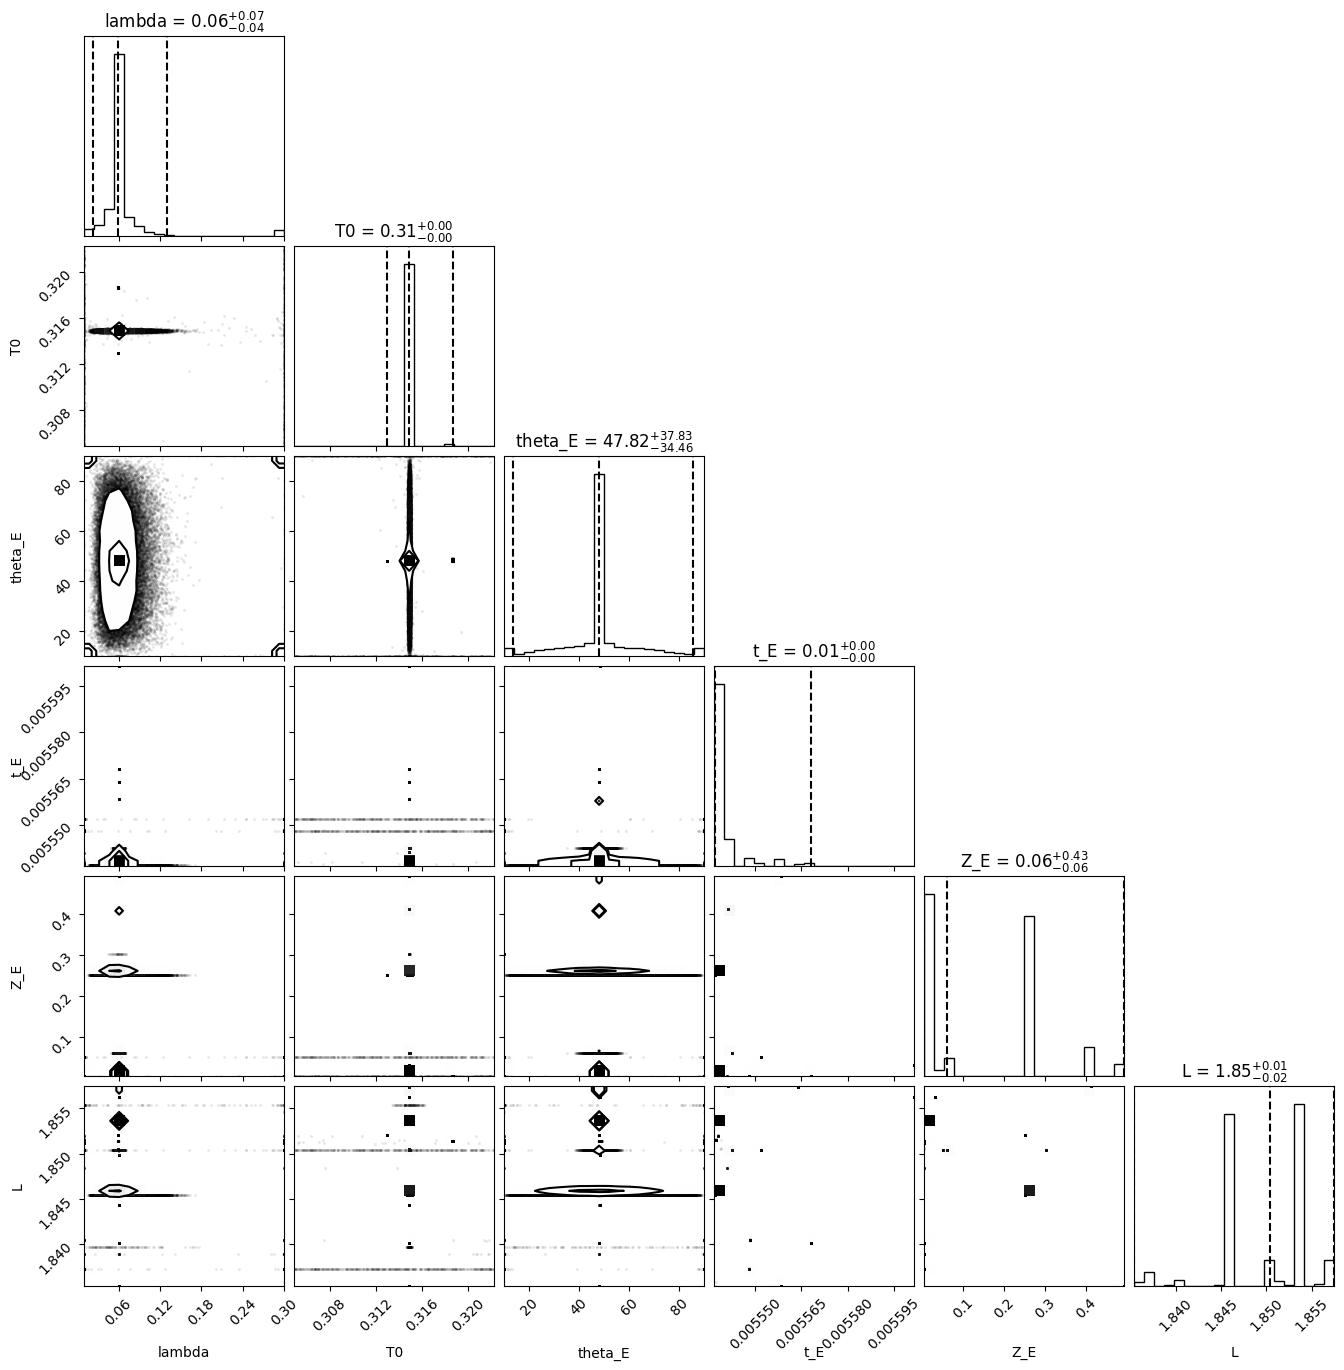

In [21]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

param_labels = ['lambda', 'T0', 'theta_E', 't_E', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [2, 98], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# Psychometrics

In [24]:
num_RHS_dict = {}
num_trials_dict = {}
for ABL in ABL_arr:
    num_RHS_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_dict[ABL] = np.zeros_like(ILD_arr)

for idx, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    if row['response_poke'] in [2,3]:
        num_trials_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if row['response_poke'] == 3:
            num_RHS_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

In [25]:
# get mean of samples
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

In [ ]:
# get the t_stim distribution
t_stim_arr = []
for idx, row in df_1.iterrows():
    if row['response_poke'] in [2,3]:
        t_stim_arr.append(row['intended_fix'])


plt.hist(t_stim_arr, bins=100, density=True)    
plt.xlabel('t_stim')
plt.ylabel('Density')
plt.title(f't_stim distribution mean={np.mean(t_stim_arr):.2f} std={np.std(t_stim_arr):.2f}');

In [ ]:
from scipy.integrate import quad
from multiprocessing import Pool

K_max = 10
t_stim = np.mean(t_stim_arr)

N_t_stim = 100

theory_psycho_dict = {}
for ABL in ABL_arr:
    theory_psycho_dict[ABL] = np.zeros_like(ILD_arr)

for ABL in ABL_arr:
    for idx, ILD in enumerate(ILD_arr):
        # Choose 100 random t_stim from real data
        random_t_stim_set = np.random.choice(t_stim_arr, N_t_stim)

        # Define the function to compute prob_up for a given random_t_stim
        def compute_prob_up(random_t_stim):
            return quad(
                up_RTs_fit_single_t_fn,
                0.001,
                10,
                args=(
                    mean_vb_params['V_A'],
                    mean_vb_params['theta_A'],
                    ABL,
                    ILD,
                    mean_vb_params['lambda'],
                    mean_vb_params['T0'],
                    mean_vb_params['theta_E'],
                    mean_vb_params['Z_E'],
                    random_t_stim,
                    mean_vb_params['t_A'],
                    mean_vb_params['t_E'],
                    mean_vb_params['t_motor'],
                    mean_vb_params['L'],
                    K_max
                )
            )[0]

        # Use multiprocessing to compute prob_up_set in parallel
        with Pool() as pool:
            prob_up_set = pool.map(compute_prob_up, random_t_stim_set)

        # Average the probabilities
        theory_psycho_dict[ABL][idx] = np.mean(prob_up_set)


In [ ]:
plt.figure(figsize=(20,5))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    plt.plot(ILD_arr, num_RHS_dict[ABL]/num_trials_dict[ABL], 'o-', label='data', color='b')
    plt.plot(ILD_arr, theory_psycho_dict[ABL], 'x-', label='theory', color='k')
    plt.title(f'ABL = {ABL}, LED OFF')
    plt.xlabel('ILD')
    plt.ylabel('P(RHS)')
    plt.legend();